/tmp/ipykernel_18817/1027771746.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average = data_df.groupby(["weekday", "since"]).mean()


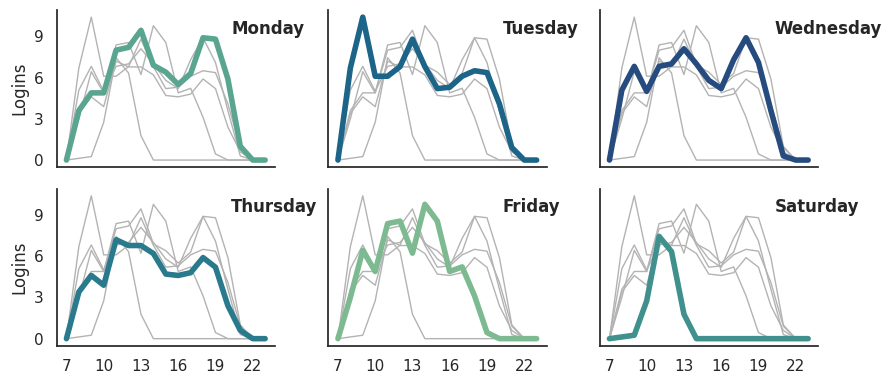

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

infile = "unifitstats.csv"
hours_start = 6
hours_end = 20

data_df = pd.read_csv(
    infile, parse_dates=["datetime"], header=0, names=["datetime", "logins", "since"]
)
data_df = data_df[
    (data_df["since"] >= hours_start) & (data_df["since"] <= hours_end)
]
data_df["weekday"] = data_df["datetime"].apply(lambda d: d.strftime("%A"))


def is_not_in_holidays(dt: datetime) -> bool:
    return not ((dt.day > 22 and dt.month == 12) or (dt.day < 7 and dt.month == 1))


data_df = data_df[
    data_df["datetime"].apply(is_not_in_holidays)
]

data_df["since"] = data_df["since"] + 2

# data_df_long = pd.DataFrame(columns=["weekday", "since"])
# for _, row in data_df.iterrows():
#      n = row["logins"]
#      data_df_long = pd.concat([data_df_long, pd.DataFrame({"weekday": [row["weekday"]]  * n, "since": [row["since"]] * n})])

# print(data_df_long.groupby("weekday").sum())

average = data_df.groupby(["weekday", "since"]).mean()
average.reset_index(inplace=True)
for wd in average["weekday"].unique():
      average = pd.concat([average, pd.DataFrame({"weekday": wd, "since": hours_start+1, "logins": 0}, index=[0])], ignore_index=True)
      average = pd.concat([average, pd.DataFrame({"weekday": wd, "since": hours_end+3, "logins": 0}, index=[0])], ignore_index=True)

g = sns.relplot(
    data=average,
    col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
    x="since",
    y="logins",
    col="weekday",
    hue="weekday",
    kind="line",
    palette="crest",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=1.5,
    legend=False,
)
for weekday, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.8, 0.85, weekday, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=average,
        x="since",
        y="logins",
        units="weekday",
        estimator=None,
        color=".7",
        linewidth=1,
        ax=ax,
    )
ax.set_xticks([7, 10, 13, 16, 19, 22])
ax.set_yticks([0, 3, 6, 9])
g.set_titles("")
g.set_axis_labels("", "Logins")
g.tight_layout()
